In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

* 沪深300指数20年5月6日开盘价为3867.26，21年4月30日开盘价为 5156.36元，收益率为33.3%

# 构建股票投资组合，数据获取。
从沪深300指数中任意选取5只股票构建投资组合，总资金100万。
资金分配权重为初始时刻在指数中的权重。
回测区间：2020/5/1 - 2021/5/1

In [18]:
#2020/5/1 - 2021/5/1 从Tushare获取数据
import tushare as ts
pro = ts.pro_api()
hs300_weight = ts.get_hs300s()

In [19]:
#策略1 收益序列
keep = []
simple_op = []
move_op = []

In [24]:
for i in range(100):
    try:
        import random
        hs300_list = [x for x in range(0,300)]
        random.shuffle(hs300_list)
        hs300_choice5 = hs300_list[0:5]

        hs300_choice5 = hs300_weight.loc[hs300_choice5]
        print(hs300_choice5)

        hs300_choice5.reset_index(inplace = True)
        hs300_choice5['invest_weight'] = hs300_choice5['weight']/sum( hs300_choice5['weight']) 
        for i in range(len(hs300_choice5['code'])):
            if str(hs300_choice5.loc[i,'code'])[0] != '6':
                hs300_choice5.loc[i,'code'] = str(hs300_choice5.loc[i,'code']) + '.SZ'
            else:
                hs300_choice5.loc[i,'code'] = str(hs300_choice5.loc[i,'code']) + '.SH'
        
        time_on = '20200501'
        time_off = '20210501'
        df_ldkg = pro.daily(ts_code=str(hs300_choice5['code'][0]), start_date=time_on, end_date=time_off)
        df_zssk = pro.daily(ts_code=str(hs300_choice5['code'][1]), start_date=time_on, end_date=time_off)
        df_ztdq = pro.daily(ts_code=str(hs300_choice5['code'][2]), start_date=time_on, end_date=time_off)
        df_zgtb = pro.daily(ts_code=str(hs300_choice5['code'][3]), start_date=time_on, end_date=time_off)
        df_xbzq = pro.daily(ts_code=str(hs300_choice5['code'][4]), start_date=time_on, end_date=time_off)

#invest_vol 初始投资额
#invest_weight 投资比重
#初始投资80万  20万留作剩余现金
        hs300_choice5['invest_vol'] = hs300_choice5['invest_weight'] * 1000000*0.8

#将数据按照日期进行排序
        df_ldkg = df_ldkg.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
        df_zssk = df_zssk.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
        df_ztdq = df_ztdq.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
        df_zgtb = df_zgtb.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
        df_xbzq = df_xbzq.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)

#stock_daily——将五只股票的2020年5月6日的 ['ts_code','trade_date','open','close'] [股票代码，交易日期，开盘价，收盘价]拼接在一起
        stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]
        daily_data = pd.concat([stock_list[0][['ts_code','trade_date','open','close']].loc[0],stock_list[1][['ts_code','trade_date','open','close']].loc[0]],axis = 1)
        n = 2
        while n <5:
            daily_data = pd.concat([daily_data,stock_list[n][['ts_code','trade_date','open','close']].loc[0]],axis = 1)
            n = n + 1
        stock_daily = daily_data.T

#hs300_choice5 沪深300的选择的五只股票的基本信息
        hs300_choice5 = hs300_choice5.reset_index()#重置索引

        hs300_choice5['ts_code'] = hs300_choice5['code']
        hs300_choice5.drop('code',axis =1,inplace =True)

#将stock_daily 与 股票详细信息拼接在一起
        stock_daily  = pd.merge(stock_daily,hs300_choice5[['name','invest_weight','invest_vol','ts_code']],on = 'ts_code')

        stock_daily['trade_cost'] = stock_daily['invest_vol'] * 0.00025#计算交易费用
        for i in stock_daily['trade_cost']:
            if i < 5:
                i = 5
        stock_daily['price_in'] = stock_daily['open']
        stock_daily['stock_num'] = stock_daily['invest_vol'] / stock_daily['price_in']
        #求2020年5月6日的现金剩余现金 trade_cost交易费用
        cash_remain = 1000000 - sum(stock_daily['trade_cost'] ) - sum(stock_daily['invest_vol'])
        print('开仓剩余现金为：',cash_remain)

#final_daily 2021年4月30日的股票详细信息 和 stock_daily 同理
        final_data = pd.concat([stock_list[0][['ts_code','trade_date','open','close']].loc[242],stock_list[1][['ts_code','trade_date','open','close']].loc[242]],axis = 1)
        n = 2
        while n <5:
            final_data = pd.concat([final_data,stock_list[n][['ts_code','trade_date','open','close']].loc[242]],axis = 1)
            n = n + 1
        final_daily = final_data.T

        stock_daily = pd.merge(stock_daily,final_daily[['ts_code','open']],on = 'ts_code')
        stock_daily['price_out'] = stock_daily['open_y']
        stock_daily['trade_cost_out'] = stock_daily['price_out']* stock_daily['stock_num']*(0.01 + 0.00025)#股票卖出的交易费用 包含印花税
        for i in  stock_daily['trade_cost_out']:
            if i < 0:
                i = 0
        stock_daily['harvest_vol'] = stock_daily['price_out']* stock_daily['stock_num']

#21年4月30日卖出股票 计算剩余现金
        cash_remain = cash_remain -sum(stock_daily['trade_cost_out']) + sum(stock_daily['harvest_vol'])
        print('平仓剩余现金为：',cash_remain)
        mark_1 = cash_remain
#策略1收益率
        mark_rate_1 = mark_1/1000000 - 1
        print('策略1收益率为',mark_rate_1)

############计算均线
# 简单平均
        def smaCal(tsPrice, k):  # 输入价格序列,Series
            Sma = pd.Series(np.nan, index = list(range(len(tsPrice))))
            for i in range(k - 1, len(tsPrice)):
                Sma[i] = sum(tsPrice[(i - k + 1):(i + 1)]) / k
            Sma.index = tsPrice.index
            return (Sma)

# 加权平均
        def wmaCal(tsPrice, weight):  # 输入价格序列,Series
            k = len(weight)
            arrWeight = np.array(weight)
            Wma = pd.Series(np.nan, index = list(range(len(tsPrice))))
            for i in range(k - 1, len(tsPrice.index)):
                Wma[i] = sum(arrWeight * tsPrice[(i - k + 1):(i + 1)])
            Wma.index = tsPrice.index
            return (Wma)

        def _ema(tsprice):
            temple = tsprice.index
            tsprice.index = list(range(len(tsprice)))
            N = len(tsprice)
            alpha = 2/(N+1)
            data = np.zeros(len(tsprice))
            for i in range(len(data)):
                data[i] = tsprice[i] if i==0 else alpha*tsprice[i]+(1-alpha)*data[i-1]
            return data[-1]
        def ewmaCal(tsprice,period):
            temple = tsprice.index
            tsprice.index = list(range(len(tsprice)))
            data = pd.Series(np.nan ,index = list(range(len(tsprice))))
            for i in range(period-1,len(tsprice)):
                data[i] = _ema(tsprice[i+1-period:i+1])
            data.index = temple
            return data

        for i in stock_list:
            i.index = i['trade_date']
    
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]
        df_ldkg_mean5 = df_ldkg[['trade_date','close']]

#简单平均
        df_ldkg_mean5 = smaCal(df_ldkg_mean5['close'],5)
        df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)
#加权平均
        df_ldkg_mean5 = df_ldkg[['trade_date','close']]
        weight = [0.10,0.15,0.20,0.25,0.30]#权重列表      
        df_ldkg_mean5 = wmaCal(df_ldkg_mean5['close'],weight)
        df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)

# 指数移动平均
        df_ldkg_mean5 = df_ldkg[['trade_date','close']]    
        df_ldkg_mean5 = ewmaCal(df_ldkg_mean5['close'],period=5)
        df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)

#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        df_ldkg_simple5 = smaCal(df_ldkg['close'],5)
        df_zssk_simple5 = smaCal(df_zssk['close'],5)
        df_ztdq_simple5 = smaCal(df_ztdq['close'],5)
        df_zgtb_simple5 = smaCal(df_zgtb['close'],5)
        df_xbzq_simple5 = smaCal(df_xbzq['close'],5)
        stockprice_simple5 = pd.DataFrame([df_ldkg_simple5,df_zssk_simple5,df_ztdq_simple5,df_zgtb_simple5,df_xbzq_simple5])
        stockprice_simple5 = stockprice_simple5.T
        stockprice_simple5.index = df_ldkg['trade_date']
        stockprice_simple5.columns = ['df_ldkg_simple5','df_zssk_simple5','df_ztdq_simple5','df_zgtb_simple5','df_xbzq_simple5']
        
        df_ldkg_simple20 = smaCal(df_ldkg['close'],20)
        df_zssk_simple20 = smaCal(df_zssk['close'],20)
        df_ztdq_simple20 = smaCal(df_ztdq['close'],20)
        df_zgtb_simple20 = smaCal(df_zgtb['close'],20)
        df_xbzq_simple20 = smaCal(df_xbzq['close'],20)
        stockprice_simple20 = pd.DataFrame([df_ldkg_simple20,df_zssk_simple20,df_ztdq_simple20,df_zgtb_simple20,df_xbzq_simple20])
        stockprice_simple20 = stockprice_simple20.T
        stockprice_simple20.index = df_ldkg['trade_date']
        stockprice_simple20.columns = ['df_ldkg_simple20','df_zssk_simple20','df_ztdq_simple20','df_zgtb_simple20','df_xbzq_simple20']
        
        #stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        df_ldkg_mean5 = ewmaCal(df_ldkg['close'],period=5)
        df_zssk_mean5 = ewmaCal(df_zssk['close'],period=5)
        df_ztdq_mean5 = ewmaCal(df_ztdq['close'],period=5)
        df_zgtb_mean5 = ewmaCal(df_zgtb['close'],period=5)
        df_xbzq_mean5 = ewmaCal(df_xbzq['close'],period=5)
        stockprice_mean5 = pd.DataFrame([df_ldkg_mean5,df_zssk_mean5,df_ztdq_mean5,df_zgtb_mean5,df_xbzq_mean5])
        stockprice_mean5 = stockprice_mean5.T
        stockprice_mean5.index = df_ldkg['trade_date']
        stockprice_mean5.columns = ['df_ldkg_mean5','df_zssk_mean5','df_ztdq_mean5','df_zgtb_mean5','df_xbzq_mean5']
        
        #stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        df_ldkg_mean20 = ewmaCal(df_ldkg['close'],period=20)
        df_zssk_mean20 = ewmaCal(df_zssk['close'],period=20)
        df_ztdq_mean20 = ewmaCal(df_ztdq['close'],period=20)
        df_zgtb_mean20 = ewmaCal(df_zgtb['close'],period=20)
        df_xbzq_mean20 = ewmaCal(df_xbzq['close'],period=20)
        stockprice_mean20 = pd.DataFrame([df_ldkg_mean20,df_zssk_mean20,df_ztdq_mean20,df_zgtb_mean20,df_xbzq_mean20])
        stockprice_mean20 = stockprice_mean20.T
        stockprice_mean20.columns = ['df_ldkg_mean20','df_zssk_mean20','df_ztdq_mean20','df_zgtb_mean20','df_xbzq_mean20']
        stockprice_mean20.index = df_ldkg['trade_date']
        
        #stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        df_ldkg = df_ldkg[['ts_code','open','close']]
        df_zssk = df_zssk[['ts_code','open','close']]
        df_ztdq = df_ztdq[['ts_code','open','close']]
        df_zgtb = df_zgtb[['ts_code','open','close']]
        df_xbzq = df_xbzq[['ts_code','open','close']]
        
        #将每个股票的各种均线合并到一个表中
        merge_list = [df_ldkg_mean5,df_ldkg_mean20,df_ldkg_simple5,df_ldkg_simple20]
        for n in range(4):
            merge_list[n] = pd.DataFrame(merge_list[n]) 
            merge_list[n].index = df_ldkg.index
            
        for df  in merge_list:
            df_ldkg = pd.merge(df_ldkg,df,on = 'trade_date')
        df_ldkg.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
        
        df_ldkg.reset_index(inplace = True)
        
        df_ldkg['trade_cost'] = 0
        df_ldkg['tax'] = 0
        df_ldkg['capital'] = 81250.00 #单只股票的总价值 包括买卖盈亏 但不包括手续费 税费
        df_ldkg['invest_vol'] = 81250.00#持仓股票价值
        df_ldkg['stock_num'] = 12675.51#持仓股票数量
        
        df_ldkg['simple_trend'] = df_ldkg['simple5'] - df_ldkg['simple20']
        
        #依据前两日短期均线和长期均线的交叉 ，向上突破 信号 signal 为买入1  向下突破 信号signal 为-1   否则维持不变 signal 0 
        for x in range(2,len(df_ldkg['simple_trend'])):
            if df_ldkg.loc[x-1,'simple_trend'] * df_ldkg.loc[x-2,'simple_trend'] < 0 and df_ldkg.loc[x-1,'simple_trend'] < 0 :
                df_ldkg.loc[x,'simple_signal'] = -1
            elif df_ldkg.loc[x-1,'simple_trend'] * df_ldkg.loc[x-2,'simple_trend'] < 0 and df_ldkg.loc[x-1,'simple_trend'] > 0:
                df_ldkg.loc[x,'simple_signal'] = 1
            else:
                df_ldkg.loc[x,'simple_signal'] = 0
                
        #依据信号股票的买入卖出  手续费trade_cost 税金 tax 单独累加计算   capital invest_vol stock_num 等持仓数据依据信号signal 更新
        for rank in range(1,len(df_ldkg['simple_signal'])):
            if df_ldkg.loc[rank ,'simple_signal'] == -1 :
                    df_ldkg.loc[rank ,'capital'] = df_ldkg.loc[rank-1 ,'capital'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] - 81250.00
                    df_ldkg.loc[rank ,'invest_vol'] = 0
                    if df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025 < 5:
                        df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + 5
                    else:
                        df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025
                    df_ldkg.loc[rank ,'tax'] = df_ldkg.loc[rank-1 ,'tax'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.01
                    df_ldkg.loc[rank ,'stock_num'] = 0
            elif df_ldkg.loc[rank ,'simple_signal'] == 1:
                    df_ldkg.loc[rank ,'invest_vol'] = 81250.00
                    df_ldkg.loc[rank ,'stock_num'] = df_ldkg.loc[rank ,'invest_vol']/df_ldkg.loc[rank ,'open']
                    df_ldkg.loc[rank ,'capital'] = df_ldkg.loc[rank-1 ,'capital']
                    if df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025 < 5:
                        df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + 5
                    else:
                        df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025
                    df_ldkg.loc[rank ,'tax'] = df_ldkg.loc[rank-1 ,'tax']
            else:
                df_ldkg.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = df_ldkg.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
                
        #stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        merge_list = [df_zssk_mean5,df_zssk_mean20,df_zssk_simple5,df_zssk_simple20]
        for n in range(4):
            merge_list[n] = pd.DataFrame(merge_list[n]) 
            merge_list[n].index = df_zssk.index
        for df  in merge_list:
            df_zssk = pd.merge(df_zssk,df,on = 'trade_date')
        df_zssk.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
        
        merge_list = [df_ztdq_mean5,df_ztdq_mean20,df_ztdq_simple5,df_ztdq_simple20]
        for n in range(4):
            merge_list[n] = pd.DataFrame(merge_list[n]) 
            merge_list[n].index = df_ztdq.index
        for df  in merge_list:
            df_ztdq = pd.merge(df_ztdq,df,on = 'trade_date')
        df_ztdq.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
        
        merge_list = [df_zgtb_mean5,df_zgtb_mean20,df_zgtb_simple5,df_zgtb_simple20]
        for n in range(4):
            merge_list[n] = pd.DataFrame(merge_list[n]) 
            merge_list[n].index = df_zgtb.index
        for df  in merge_list:
            df_zgtb = pd.merge(df_zgtb,df,on = 'trade_date')
        df_zgtb.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
        
        merge_list = [df_xbzq_mean5,df_xbzq_mean20,df_xbzq_simple5,df_xbzq_simple20]
        for n in range(4):
            merge_list[n] = pd.DataFrame(merge_list[n]) 
            merge_list[n].index = df_xbzq.index
        for df  in merge_list:
            df_xbzq = pd.merge(df_xbzq,df,on = 'trade_date')
        df_xbzq.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']
        
        #依据以上的代码定义一个依据简单平均均线的更新股票每日数据的函数
        def simple_stockdaily(data,invest_vol,stock_num):
            data.reset_index(inplace = True)
            data['trade_cost'] = 0
            data['tax'] = 0
            data['capital'] = invest_vol
            data['invest_vol'] = invest_vol
            data['stock_num'] = stock_num
            data['simple_trend'] = data['simple5'] - data['simple20']
            for x in range(2,len(data['simple_trend'])):
                if data.loc[x-1,'simple_trend'] * data.loc[x-2,'simple_trend'] < 0 and data.loc[x-1,'simple_trend'] < 0 :
                    data.loc[x,'simple_signal'] = -1
                elif data.loc[x-1,'simple_trend'] * data.loc[x-2,'simple_trend'] < 0 and data.loc[x-1,'simple_trend'] > 0:
                    data.loc[x,'simple_signal'] = 1
                else:
                    data.loc[x,'simple_signal'] = 0
            for rank in range(1,len(data['simple_signal'])):
                if data.loc[rank ,'simple_signal'] == -1 :
                        data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] - invest_vol
                        data.loc[rank ,'invest_vol'] = 0
                        if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                        else:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                        data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.01
                        data.loc[rank ,'stock_num'] = 0
                elif data.loc[rank ,'simple_signal'] == 1:
                        data.loc[rank ,'invest_vol'] = invest_vol
                        data.loc[rank ,'stock_num'] = data.loc[rank ,'invest_vol']/data.loc[rank ,'open']
                        data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital']
                        if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                        else:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                        data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax']
                else:
                    data.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = data.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
            return data
        
        ##依据以上的代码定义一个依据指数均线的更新股票每日数据的函数
        def mean_stockdaily(data,invest_vol,stock_num):
            data.reset_index(inplace = True)
            data['trade_cost'] = 0
            data['tax'] = 0
            data['capital'] = invest_vol
            data['invest_vol'] = invest_vol
            data['stock_num'] = stock_num
            data['mean_trend'] = data['mean5'] - data['mean20']
            for x in range(2,len(data['mean_trend'])):
                if data.loc[x-1,'mean_trend'] * data.loc[x-2,'mean_trend'] < 0 and data.loc[x-1,'mean_trend'] < 0 :
                    data.loc[x,'mean_signal'] = -1
                elif data.loc[x-1,'mean_trend'] * data.loc[x-2,'mean_trend'] < 0 and data.loc[x-1,'mean_trend'] > 0:
                    data.loc[x,'mean_signal'] = 1
                else:
                    data.loc[x,'mean_signal'] = 0
            for rank in range(1,len(data['simple_signal'])):
                if data.loc[rank ,'mean_signal'] == -1 :
                        data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] - invest_vol
                        data.loc[rank ,'invest_vol'] = 0
                        if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                        else:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                        data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.01
                        data.loc[rank ,'stock_num'] = 0
                elif data.loc[rank ,'mean_signal'] == 1:
                        data.loc[rank ,'invest_vol'] = invest_vol
                        data.loc[rank ,'stock_num'] = data.loc[rank ,'invest_vol']/data.loc[rank ,'open']
                        data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital']
                        if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                        else:
                            data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                        data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax']
                else:
                    data.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = data.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
            return data
        
        #stock_re['remain_capital_sum'] 剩余现金的每日dataframe 依据以上的函数实现
        #stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        df_zssk = simple_stockdaily(df_zssk,162500.00,8699.14)
        df_ztdq = simple_stockdaily(df_ztdq,125000.00,5351.03)
        df_zgtb = simple_stockdaily(df_zgtb,368750.00,10757.00)
        df_xbzq = simple_stockdaily(df_xbzq,62500.00,8311.17)
        stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        for stock in stock_list:
            stock['remain_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax'] - stock['invest_vol']
        df_ldkg_re = df_ldkg[['remain_capital']]
        df_zssk_re = df_zssk[['remain_capital']]
        df_ztdq_re = df_ztdq[['remain_capital']]
        df_zgtb_re = df_zgtb[['remain_capital']]
        df_xbzq_re = df_xbzq[['remain_capital']]
        cols = ['df_ldkg_re','df_zssk_re','df_ztdq_re','df_zgtb_re','df_xbzq_re']
        stock_re = pd.concat([df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re],axis = 1)
        stock_re.columns = cols
        stock_re['remain_capital_sum'] = 199800.0+stock_re['df_ldkg_re']+stock_re['df_zssk_re']+stock_re['df_ztdq_re']+stock_re['df_zgtb_re']+stock_re['df_xbzq_re']
        stock_re.index = df_ldkg['trade_date']
        
        #stock_to['total_capital_sum'] 股票总价值的d每日ataframe更新 依据以上的函数实现
        stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        for stock in stock_list:
            stock['total_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax']
        df_ldkg_to = df_ldkg[['total_capital']]
        df_zssk_to = df_zssk[['total_capital']]
        df_ztdq_to = df_ztdq[['total_capital']]
        df_zgtb_to = df_zgtb[['total_capital']]
        df_xbzq_to = df_xbzq[['total_capital']]
        cols = ['df_ldkg_to','df_zssk_to','df_ztdq_to','df_zgtb_to','df_xbzq_to']
        stock_to = pd.concat([df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to],axis = 1)
        stock_to.columns = cols
        stock_to['total_capital_sum'] = stock_to['df_ldkg_to']+stock_to['df_zssk_to']+stock_to['df_ztdq_to']+stock_to['df_zgtb_to']+stock_to['df_xbzq_to']
        
        #抠出简单平均信号的收益率
        mark_2 = stock_to['total_capital_sum'][242]
        mark_rate_2 = mark_2/1000000 - 1
        print('简单平均操作收益率为',mark_rate_2)
        stock_to.index = df_ldkg['trade_date']
        simple_rev = np.array(stock_to['total_capital_sum'])#这个simple_rev 是简单平均均线策略的每日收益的序列
        
        #以下实现的原理和简单平均相同
        df_ldkg = mean_stockdaily(df_ldkg,81250.00,11363.64)
        df_zssk = mean_stockdaily(df_zssk,162500.00,8699.14)
        df_ztdq = mean_stockdaily(df_ztdq,125000.00,5351.03)
        df_zgtb = mean_stockdaily(df_zgtb,368750.00,10757.00)
        df_xbzq = mean_stockdaily(df_xbzq,62500.00,8311.17)###算出每一个股票的
        stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        for stock in stock_list:
            stock['remain_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax'] - stock['invest_vol']
        df_ldkg_re = df_ldkg[['remain_capital']]
        df_zssk_re = df_zssk[['remain_capital']]
        df_ztdq_re = df_ztdq[['remain_capital']]
        df_zgtb_re = df_zgtb[['remain_capital']]
        df_xbzq_re = df_xbzq[['remain_capital']]
        cols = ['df_ldkg_re','df_zssk_re','df_ztdq_re','df_zgtb_re','df_xbzq_re']
        stock_re = pd.concat([df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re],axis = 1)
        stock_re.columns = cols
        stock_re['remain_capital_sum'] = 199800.0+stock_re['df_ldkg_re']+stock_re['df_zssk_re']+stock_re['df_ztdq_re']+stock_re['df_zgtb_re']+stock_re['df_xbzq_re']
        stock_re.index = df_ldkg['trade_date']
        
        stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
        for stock in stock_list:
            stock['total_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax']
        df_ldkg_to = df_ldkg[['total_capital']]
        df_zssk_to = df_zssk[['total_capital']]
        df_ztdq_to = df_ztdq[['total_capital']]
        df_zgtb_to = df_zgtb[['total_capital']]
        df_xbzq_to = df_xbzq[['total_capital']]
        cols = ['df_ldkg_to','df_zssk_to','df_ztdq_to','df_zgtb_to','df_xbzq_to']
        stock_to = pd.concat([df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to],axis = 1)
        stock_to.columns = cols
        stock_to['total_capital_sum'] = stock_to['df_ldkg_to']+stock_to['df_zssk_to']+stock_to['df_ztdq_to']+stock_to['df_zgtb_to']+stock_to['df_xbzq_to']
        
        #抠出移动平均的收益率
        mark_3 = stock_to['total_capital_sum'][242]
        mark_rate_3 = mark_3/1000000 - 1
        print('移动平均操作收益率为',mark_rate_2)
        stock_to.index = df_ldkg['trade_date']
        mean_rev = np.array(stock_to['total_capital_sum'])#这个mean_rev 是指数平均均线策略的每日收益的序列
        keep.append(mark_rate_1)
        simple_op.append(mark_rate_2)
        move_op.append(mark_rate_3)
        
    except :
        print('组合中有上市不足一年的的股票')
        continue

          date    code  name  weight
139 2021-04-30  601727  上海电气    0.10
84  2021-04-30  600918  中泰证券    0.04
284 2021-04-30  300033   同花顺    0.12
62  2021-04-30  600600  青岛啤酒    0.17
254 2021-04-30  002460  赣锋锂业    0.43
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
47  2021-04-30  600390  五矿资本    0.07
3   2021-04-30  600010  包钢股份    0.17
39  2021-04-30  600309  万华化学    0.84
257 2021-04-30  002493  荣盛石化    0.30
164 2021-04-30  603019  中科曙光    0.14
开仓剩余现金为： 199800.0
平仓剩余现金为： 1807007.761735425
策略1收益率为 0.807007761735425
简单平均操作收益率为 0.23495025464341968
移动平均操作收益率为 0.23495025464341968
          date    code  name  weight
146 2021-04-30  601838  成都银行    0.13
81  2021-04-30  600887  伊利股份    1.29
183 2021-04-30  688036  传音控股    0.14
175 2021-04-30  603799  华友钴业    0.31
233 2021-04-30  002142  宁波银行    0.66
开仓剩余现金为： 199800.0
平仓剩余现金为： 1552178.1304114177
策略1收益率为 0.5521781304114177
简单平均操作收益率为 0.6373651314857047
移动平均操作收益率为 0.6373651314857047
          date    code  name  weigh

开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
69  2021-04-30  600705  中航资本    0.11
32  2021-04-30  600196  复星医药    0.38
268 2021-04-30  002714  牧原股份    1.10
8   2021-04-30  600019  宝钢股份    0.40
132 2021-04-30  601633  长城汽车    0.21
开仓剩余现金为： 199800.00000000012
平仓剩余现金为： 1408975.903223592
策略1收益率为 0.408975903223592
简单平均操作收益率为 0.07438838808070636
移动平均操作收益率为 0.07438838808070636
          date    code  name  weight
6   2021-04-30  600016  民生银行    0.52
222 2021-04-30  002001   新和成    0.26
144 2021-04-30  601816  京沪高铁    0.11
101 2021-04-30  601117  中国化学    0.08
63  2021-04-30  600606  绿地控股    0.11
开仓剩余现金为： 199800.00000000012
组合中有上市不足一年的的股票
          date    code  name  weight
164 2021-04-30  603019  中科曙光    0.14
115 2021-04-30  601238  广汽集团    0.05
297 2021-04-30  300601  康泰生物    0.32
226 2021-04-30  002027  分众传媒    0.57
231 2021-04-30  002120  韵达股份    0.10
开仓剩余现金为： 199800.00000000012
平仓剩余现金为： 1440624.925885713
策略1收益率为 0.4406249258857129
简单平均操作收益率为 0.3137267022008987
移动平

简单平均操作收益率为 -0.13245203738248368
移动平均操作收益率为 -0.13245203738248368
          date    code  name  weight
28  2021-04-30  600161  天坛生物    0.13
160 2021-04-30  601988  中国银行    0.36
197 2021-04-30  000596  古井贡酒    0.14
95  2021-04-30  601066  中信建投    0.14
163 2021-04-30  601998  中信银行    0.08
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1065050.2020471946
策略1收益率为 0.06505020204719458
简单平均操作收益率为 0.733374999840136
移动平均操作收益率为 0.733374999840136
          date    code  name  weight
71  2021-04-30  600745  闻泰科技    0.22
173 2021-04-30  603501  韦尔股份    0.68
82  2021-04-30  600893  航发动力    0.21
224 2021-04-30  002008  大族激光    0.18
124 2021-04-30  601398  工商银行    0.93
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
196 2021-04-30  000568  泸州老窖    0.97
246 2021-04-30  002352  顺丰控股    0.61
160 2021-04-30  601988  中国银行    0.36
40  2021-04-30  600332   白云山    0.09
34  2021-04-30  600233  圆通速递    0.08
开仓剩余现金为： 199799.99999999988
组合中有上市不足一年的的股票
          date    code   name  weight
286 2021-04-30

开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1191096.2494722544
策略1收益率为 0.19109624947225434
简单平均操作收益率为 1.255728181932413
移动平均操作收益率为 1.255728181932413
          date    code  name  weight
177 2021-04-30  603899  晨光文具    0.18
155 2021-04-30  601916  浙商银行    0.07
71  2021-04-30  600745  闻泰科技    0.22
55  2021-04-30  600519  贵州茅台    5.22
233 2021-04-30  002142  宁波银行    0.66
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
278 2021-04-30  002945  华林证券    0.02
27  2021-04-30  600150  中国船舶    0.05
48  2021-04-30  600406  国电南瑞    0.38
258 2021-04-30  002508  老板电器    0.09
84  2021-04-30  600918  中泰证券    0.04
开仓剩余现金为： 199800.0
组合中有上市不足一年的的股票
          date    code  name  weight
207 2021-04-30  000725  京东方A    1.03
48  2021-04-30  600406  国电南瑞    0.38
209 2021-04-30  000768  中航西飞    0.17
170 2021-04-30  603288  海天味业    0.85
293 2021-04-30  300413  芒果超媒    0.25
开仓剩余现金为： 199799.99999999988
平仓剩余现金为： 1520067.5739832697
策略1收益率为 0.5200675739832696
简单平均操作收益率为 1.3261491277141757
移动平均操作收益率为 1.

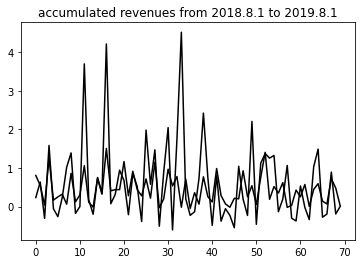

In [27]:
x = list(range(70))
y1 = keep
y2 = simple_op
plt.plot(x,y1,color = 'k')
plt.plot(x,y2,color = 'k')
plt.title('accumulated revenues from 2018.8.1 to 2019.8.1')
plt.show()

下面是随机获取一个股票组合（5）的收益率源代码

import random
hs300_list = [x for x in range(0,300)]
random.shuffle(hs300_list)
hs300_choice5 = hs300_list[0:5]

hs300_choice5 = hs300_weight.loc[hs300_choice5]
print(hs300_choice5)

hs300_choice5.reset_index(inplace = True)
hs300_choice5['invest_weight'] = hs300_choice5['weight']/sum( hs300_choice5['weight']) 
for i in range(len(hs300_choice5['code'])):
    if str(hs300_choice5.loc[i,'code'])[0] != '6':
        hs300_choice5.loc[i,'code'] = str(hs300_choice5.loc[i,'code']) + '.SZ'
    else:
        hs300_choice5.loc[i,'code'] = str(hs300_choice5.loc[i,'code']) + '.SH'
        
time_on = '20200501'
time_off = '20210501'
df_ldkg = pro.daily(ts_code=str(hs300_choice5['code'][0]), start_date=time_on, end_date=time_off)
df_zssk = pro.daily(ts_code=str(hs300_choice5['code'][1]), start_date=time_on, end_date=time_off)
df_ztdq = pro.daily(ts_code=str(hs300_choice5['code'][2]), start_date=time_on, end_date=time_off)
df_zgtb = pro.daily(ts_code=str(hs300_choice5['code'][3]), start_date=time_on, end_date=time_off)
df_xbzq = pro.daily(ts_code=str(hs300_choice5['code'][4]), start_date=time_on, end_date=time_off)

#invest_vol 初始投资额
#invest_weight 投资比重
#初始投资80万  20万留作剩余现金
hs300_choice5['invest_vol'] = hs300_choice5['invest_weight'] * 1000000*0.8

#将数据按照日期进行排序
df_ldkg = df_ldkg.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_zssk = df_zssk.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_ztdq = df_ztdq.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_zgtb = df_zgtb.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)
df_xbzq = df_xbzq.sort_values(by = 'trade_date',ascending = True).reset_index(drop = True)

#stock_daily——将五只股票的2020年5月6日的 ['ts_code','trade_date','open','close'] [股票代码，交易日期，开盘价，收盘价]拼接在一起
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]
daily_data = pd.concat([stock_list[0][['ts_code','trade_date','open','close']].loc[0],stock_list[1][['ts_code','trade_date','open','close']].loc[0]],axis = 1)
n = 2
while n <5:
    daily_data = pd.concat([daily_data,stock_list[n][['ts_code','trade_date','open','close']].loc[0]],axis = 1)
    n = n + 1
stock_daily = daily_data.T

#hs300_choice5 沪深300的选择的五只股票的基本信息
hs300_choice5 = hs300_choice5.reset_index()#重置索引

hs300_choice5['ts_code'] = hs300_choice5['code']
hs300_choice5.drop('code',axis =1,inplace =True)

#将stock_daily 与 股票详细信息拼接在一起
stock_daily  = pd.merge(stock_daily,hs300_choice5[['name','invest_weight','invest_vol','ts_code']],on = 'ts_code')

stock_daily['trade_cost'] = stock_daily['invest_vol'] * 0.00025#计算交易费用
for i in stock_daily['trade_cost']:
    if i < 5:
        i = 5
stock_daily['price_in'] = stock_daily['open']
stock_daily['stock_num'] = stock_daily['invest_vol'] / stock_daily['price_in']
#求2020年5月6日的现金剩余现金 trade_cost交易费用
cash_remain = 1000000 - sum(stock_daily['trade_cost'] ) - sum(stock_daily['invest_vol'])
print('开仓剩余现金为：',cash_remain)

#final_daily 2021年4月30日的股票详细信息 和 stock_daily 同理
final_data = pd.concat([stock_list[0][['ts_code','trade_date','open','close']].loc[242],stock_list[1][['ts_code','trade_date','open','close']].loc[242]],axis = 1)
n = 2
while n <5:
    final_data = pd.concat([final_data,stock_list[n][['ts_code','trade_date','open','close']].loc[242]],axis = 1)
    n = n + 1
final_daily = final_data.T

stock_daily = pd.merge(stock_daily,final_daily[['ts_code','open']],on = 'ts_code')
stock_daily['price_out'] = stock_daily['open_y']
stock_daily['trade_cost_out'] = stock_daily['price_out']* stock_daily['stock_num']*(0.01 + 0.00025)#股票卖出的交易费用 包含印花税
for i in  stock_daily['trade_cost_out']:
    if i < 0:
        i = 0
stock_daily['harvest_vol'] = stock_daily['price_out']* stock_daily['stock_num']

#21年4月30日卖出股票 计算剩余现金
cash_remain = cash_remain -sum(stock_daily['trade_cost_out']) + sum(stock_daily['harvest_vol'])
print('平仓剩余现金为：',cash_remain)
mark_1 = cash_remain
#策略1收益率
mark_rate_1 = mark_1/1000000 - 1
print('策略1收益率为',mark_rate_1)

############计算均线
# 简单平均
def smaCal(tsPrice, k):  # 输入价格序列,Series
    Sma = pd.Series(np.nan, index = list(range(len(tsPrice))))
    for i in range(k - 1, len(tsPrice)):
        Sma[i] = sum(tsPrice[(i - k + 1):(i + 1)]) / k
    Sma.index = tsPrice.index
    return (Sma)

# 加权平均
def wmaCal(tsPrice, weight):  # 输入价格序列,Series
    k = len(weight)
    arrWeight = np.array(weight)
    Wma = pd.Series(np.nan, index = list(range(len(tsPrice))))
    for i in range(k - 1, len(tsPrice.index)):
        Wma[i] = sum(arrWeight * tsPrice[(i - k + 1):(i + 1)])
    Wma.index = tsPrice.index
    return (Wma)

def _ema(tsprice):
    temple = tsprice.index
    tsprice.index = list(range(len(tsprice)))
    N = len(tsprice)
    alpha = 2/(N+1)
    data = np.zeros(len(tsprice))
    for i in range(len(data)):
        data[i] = tsprice[i] if i==0 else alpha*tsprice[i]+(1-alpha)*data[i-1]
    return data[-1]
def ewmaCal(tsprice,period):
    temple = tsprice.index
    tsprice.index = list(range(len(tsprice)))
    data = pd.Series(np.nan ,index = list(range(len(tsprice))))
    for i in range(period-1,len(tsprice)):
        data[i] = _ema(tsprice[i+1-period:i+1])
    data.index = temple
    return data

for i in stock_list:
    i.index = i['trade_date']
    
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]
df_ldkg_mean5 = df_ldkg[['trade_date','close']]

#简单平均
df_ldkg_mean5 = smaCal(df_ldkg_mean5['close'],5)
df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)
#加权平均
df_ldkg_mean5 = df_ldkg[['trade_date','close']]
weight = [0.10,0.15,0.20,0.25,0.30]#权重列表      
df_ldkg_mean5 = wmaCal(df_ldkg_mean5['close'],weight)
df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)

# 指数移动平均
df_ldkg_mean5 = df_ldkg[['trade_date','close']]    
df_ldkg_mean5 = ewmaCal(df_ldkg_mean5['close'],period=5)
df_ldkg_mean5 = pd.DataFrame(df_ldkg_mean5)

#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg_simple5 = smaCal(df_ldkg['close'],5)
df_zssk_simple5 = smaCal(df_zssk['close'],5)
df_ztdq_simple5 = smaCal(df_ztdq['close'],5)
df_zgtb_simple5 = smaCal(df_zgtb['close'],5)
df_xbzq_simple5 = smaCal(df_xbzq['close'],5)
stockprice_simple5 = pd.DataFrame([df_ldkg_simple5,df_zssk_simple5,df_ztdq_simple5,df_zgtb_simple5,df_xbzq_simple5])
stockprice_simple5 = stockprice_simple5.T
stockprice_simple5.index = df_ldkg['trade_date']
stockprice_simple5.columns = ['df_ldkg_simple5','df_zssk_simple5','df_ztdq_simple5','df_zgtb_simple5','df_xbzq_simple5']

df_ldkg_simple20 = smaCal(df_ldkg['close'],20)
df_zssk_simple20 = smaCal(df_zssk['close'],20)
df_ztdq_simple20 = smaCal(df_ztdq['close'],20)
df_zgtb_simple20 = smaCal(df_zgtb['close'],20)
df_xbzq_simple20 = smaCal(df_xbzq['close'],20)
stockprice_simple20 = pd.DataFrame([df_ldkg_simple20,df_zssk_simple20,df_ztdq_simple20,df_zgtb_simple20,df_xbzq_simple20])
stockprice_simple20 = stockprice_simple20.T
stockprice_simple20.index = df_ldkg['trade_date']
stockprice_simple20.columns = ['df_ldkg_simple20','df_zssk_simple20','df_ztdq_simple20','df_zgtb_simple20','df_xbzq_simple20']

#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg_mean5 = ewmaCal(df_ldkg['close'],period=5)
df_zssk_mean5 = ewmaCal(df_zssk['close'],period=5)
df_ztdq_mean5 = ewmaCal(df_ztdq['close'],period=5)
df_zgtb_mean5 = ewmaCal(df_zgtb['close'],period=5)
df_xbzq_mean5 = ewmaCal(df_xbzq['close'],period=5)
stockprice_mean5 = pd.DataFrame([df_ldkg_mean5,df_zssk_mean5,df_ztdq_mean5,df_zgtb_mean5,df_xbzq_mean5])
stockprice_mean5 = stockprice_mean5.T
stockprice_mean5.index = df_ldkg['trade_date']
stockprice_mean5.columns = ['df_ldkg_mean5','df_zssk_mean5','df_ztdq_mean5','df_zgtb_mean5','df_xbzq_mean5']

#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg_mean20 = ewmaCal(df_ldkg['close'],period=20)
df_zssk_mean20 = ewmaCal(df_zssk['close'],period=20)
df_ztdq_mean20 = ewmaCal(df_ztdq['close'],period=20)
df_zgtb_mean20 = ewmaCal(df_zgtb['close'],period=20)
df_xbzq_mean20 = ewmaCal(df_xbzq['close'],period=20)
stockprice_mean20 = pd.DataFrame([df_ldkg_mean20,df_zssk_mean20,df_ztdq_mean20,df_zgtb_mean20,df_xbzq_mean20])
stockprice_mean20 = stockprice_mean20.T
stockprice_mean20.columns = ['df_ldkg_mean20','df_zssk_mean20','df_ztdq_mean20','df_zgtb_mean20','df_xbzq_mean20']
stockprice_mean20.index = df_ldkg['trade_date']

#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_ldkg = df_ldkg[['ts_code','open','close']]
df_zssk = df_zssk[['ts_code','open','close']]
df_ztdq = df_ztdq[['ts_code','open','close']]
df_zgtb = df_zgtb[['ts_code','open','close']]
df_xbzq = df_xbzq[['ts_code','open','close']]

#将每个股票的各种均线合并到一个表中
merge_list = [df_ldkg_mean5,df_ldkg_mean20,df_ldkg_simple5,df_ldkg_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_ldkg.index
    
for df  in merge_list:
    df_ldkg = pd.merge(df_ldkg,df,on = 'trade_date')
df_ldkg.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

df_ldkg.reset_index(inplace = True)

df_ldkg['trade_cost'] = 0
df_ldkg['tax'] = 0
df_ldkg['capital'] = 81250.00 #单只股票的总价值 包括买卖盈亏 但不包括手续费 税费
df_ldkg['invest_vol'] = 81250.00#持仓股票价值
df_ldkg['stock_num'] = 12675.51#持仓股票数量

df_ldkg['simple_trend'] = df_ldkg['simple5'] - df_ldkg['simple20']

#依据前两日短期均线和长期均线的交叉 ，向上突破 信号 signal 为买入1  向下突破 信号signal 为-1   否则维持不变 signal 0 
for x in range(2,len(df_ldkg['simple_trend'])):
    if df_ldkg.loc[x-1,'simple_trend'] * df_ldkg.loc[x-2,'simple_trend'] < 0 and df_ldkg.loc[x-1,'simple_trend'] < 0 :
        df_ldkg.loc[x,'simple_signal'] = -1
    elif df_ldkg.loc[x-1,'simple_trend'] * df_ldkg.loc[x-2,'simple_trend'] < 0 and df_ldkg.loc[x-1,'simple_trend'] > 0:
        df_ldkg.loc[x,'simple_signal'] = 1
    else:
        df_ldkg.loc[x,'simple_signal'] = 0
        
#依据信号股票的买入卖出  手续费trade_cost 税金 tax 单独累加计算   capital invest_vol stock_num 等持仓数据依据信号signal 更新
for rank in range(1,len(df_ldkg['simple_signal'])):
    if df_ldkg.loc[rank ,'simple_signal'] == -1 :
            df_ldkg.loc[rank ,'capital'] = df_ldkg.loc[rank-1 ,'capital'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] - 81250.00
            df_ldkg.loc[rank ,'invest_vol'] = 0
            if df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025 < 5:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + 5
            else:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025
            df_ldkg.loc[rank ,'tax'] = df_ldkg.loc[rank-1 ,'tax'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.01
            df_ldkg.loc[rank ,'stock_num'] = 0
    elif df_ldkg.loc[rank ,'simple_signal'] == 1:
            df_ldkg.loc[rank ,'invest_vol'] = 81250.00
            df_ldkg.loc[rank ,'stock_num'] = df_ldkg.loc[rank ,'invest_vol']/df_ldkg.loc[rank ,'open']
            df_ldkg.loc[rank ,'capital'] = df_ldkg.loc[rank-1 ,'capital']
            if df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025 < 5:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + 5
            else:
                df_ldkg.loc[rank ,'trade_cost'] = df_ldkg.loc[rank-1 ,'trade_cost'] + df_ldkg.loc[rank-1,'stock_num'] * df_ldkg.loc[rank ,'open'] * 0.00025
            df_ldkg.loc[rank ,'tax'] = df_ldkg.loc[rank-1 ,'tax']
    else:
        df_ldkg.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = df_ldkg.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
        
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
merge_list = [df_zssk_mean5,df_zssk_mean20,df_zssk_simple5,df_zssk_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_zssk.index
for df  in merge_list:
    df_zssk = pd.merge(df_zssk,df,on = 'trade_date')
df_zssk.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

merge_list = [df_ztdq_mean5,df_ztdq_mean20,df_ztdq_simple5,df_ztdq_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_ztdq.index
for df  in merge_list:
    df_ztdq = pd.merge(df_ztdq,df,on = 'trade_date')
df_ztdq.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

merge_list = [df_zgtb_mean5,df_zgtb_mean20,df_zgtb_simple5,df_zgtb_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_zgtb.index
for df  in merge_list:
    df_zgtb = pd.merge(df_zgtb,df,on = 'trade_date')
df_zgtb.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

merge_list = [df_xbzq_mean5,df_xbzq_mean20,df_xbzq_simple5,df_xbzq_simple20]
for n in range(4):
    merge_list[n] = pd.DataFrame(merge_list[n]) 
    merge_list[n].index = df_xbzq.index
for df  in merge_list:
    df_xbzq = pd.merge(df_xbzq,df,on = 'trade_date')
df_xbzq.columns = ['ts_code','open','close','mean5','mean20','simple5','simple20']

#依据以上的代码定义一个依据简单平均均线的更新股票每日数据的函数
def simple_stockdaily(data,invest_vol,stock_num):
    data.reset_index(inplace = True)
    data['trade_cost'] = 0
    data['tax'] = 0
    data['capital'] = invest_vol
    data['invest_vol'] = invest_vol
    data['stock_num'] = stock_num
    data['simple_trend'] = data['simple5'] - data['simple20']
    for x in range(2,len(data['simple_trend'])):
        if data.loc[x-1,'simple_trend'] * data.loc[x-2,'simple_trend'] < 0 and data.loc[x-1,'simple_trend'] < 0 :
            data.loc[x,'simple_signal'] = -1
        elif data.loc[x-1,'simple_trend'] * data.loc[x-2,'simple_trend'] < 0 and data.loc[x-1,'simple_trend'] > 0:
            data.loc[x,'simple_signal'] = 1
        else:
            data.loc[x,'simple_signal'] = 0
    for rank in range(1,len(data['simple_signal'])):
        if data.loc[rank ,'simple_signal'] == -1 :
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] - invest_vol
                data.loc[rank ,'invest_vol'] = 0
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.01
                data.loc[rank ,'stock_num'] = 0
        elif data.loc[rank ,'simple_signal'] == 1:
                data.loc[rank ,'invest_vol'] = invest_vol
                data.loc[rank ,'stock_num'] = data.loc[rank ,'invest_vol']/data.loc[rank ,'open']
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital']
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax']
        else:
            data.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = data.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
    return data

##依据以上的代码定义一个依据指数均线的更新股票每日数据的函数
def mean_stockdaily(data,invest_vol,stock_num):
    data.reset_index(inplace = True)
    data['trade_cost'] = 0
    data['tax'] = 0
    data['capital'] = invest_vol
    data['invest_vol'] = invest_vol
    data['stock_num'] = stock_num
    data['mean_trend'] = data['mean5'] - data['mean20']
    for x in range(2,len(data['mean_trend'])):
        if data.loc[x-1,'mean_trend'] * data.loc[x-2,'mean_trend'] < 0 and data.loc[x-1,'mean_trend'] < 0 :
            data.loc[x,'mean_signal'] = -1
        elif data.loc[x-1,'mean_trend'] * data.loc[x-2,'mean_trend'] < 0 and data.loc[x-1,'mean_trend'] > 0:
            data.loc[x,'mean_signal'] = 1
        else:
            data.loc[x,'mean_signal'] = 0
    for rank in range(1,len(data['simple_signal'])):
        if data.loc[rank ,'mean_signal'] == -1 :
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] - invest_vol
                data.loc[rank ,'invest_vol'] = 0
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.01
                data.loc[rank ,'stock_num'] = 0
        elif data.loc[rank ,'mean_signal'] == 1:
                data.loc[rank ,'invest_vol'] = invest_vol
                data.loc[rank ,'stock_num'] = data.loc[rank ,'invest_vol']/data.loc[rank ,'open']
                data.loc[rank ,'capital'] = data.loc[rank-1 ,'capital']
                if data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025 < 5:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + 5
                else:
                    data.loc[rank ,'trade_cost'] = data.loc[rank-1 ,'trade_cost'] + data.loc[rank-1,'stock_num'] * data.loc[rank ,'open'] * 0.00025
                data.loc[rank ,'tax'] = data.loc[rank-1 ,'tax']
        else:
            data.loc[rank,['capital','invest_vol','trade_cost','tax','stock_num']] = data.loc[rank-1,['capital','invest_vol','trade_cost','tax','stock_num']]
    return data

#stock_re['remain_capital_sum'] 剩余现金的每日dataframe 依据以上的函数实现
#stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
df_zssk = simple_stockdaily(df_zssk,162500.00,8699.14)
df_ztdq = simple_stockdaily(df_ztdq,125000.00,5351.03)
df_zgtb = simple_stockdaily(df_zgtb,368750.00,10757.00)
df_xbzq = simple_stockdaily(df_xbzq,62500.00,8311.17)
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['remain_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax'] - stock['invest_vol']
df_ldkg_re = df_ldkg[['remain_capital']]
df_zssk_re = df_zssk[['remain_capital']]
df_ztdq_re = df_ztdq[['remain_capital']]
df_zgtb_re = df_zgtb[['remain_capital']]
df_xbzq_re = df_xbzq[['remain_capital']]
cols = ['df_ldkg_re','df_zssk_re','df_ztdq_re','df_zgtb_re','df_xbzq_re']
stock_re = pd.concat([df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re],axis = 1)
stock_re.columns = cols
stock_re['remain_capital_sum'] = 199800.0+stock_re['df_ldkg_re']+stock_re['df_zssk_re']+stock_re['df_ztdq_re']+stock_re['df_zgtb_re']+stock_re['df_xbzq_re']
stock_re.index = df_ldkg['trade_date']

#stock_to['total_capital_sum'] 股票总价值的d每日ataframe更新 依据以上的函数实现
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['total_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax']
df_ldkg_to = df_ldkg[['total_capital']]
df_zssk_to = df_zssk[['total_capital']]
df_ztdq_to = df_ztdq[['total_capital']]
df_zgtb_to = df_zgtb[['total_capital']]
df_xbzq_to = df_xbzq[['total_capital']]
cols = ['df_ldkg_to','df_zssk_to','df_ztdq_to','df_zgtb_to','df_xbzq_to']
stock_to = pd.concat([df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to],axis = 1)
stock_to.columns = cols
stock_to['total_capital_sum'] = stock_to['df_ldkg_to']+stock_to['df_zssk_to']+stock_to['df_ztdq_to']+stock_to['df_zgtb_to']+stock_to['df_xbzq_to']

#抠出简单平均信号的收益率
mark_2 = stock_to['total_capital_sum'][242]
mark_rate_2 = mark_2/1000000 - 1
print('简单平均操作收益率为',mark_rate_2)
stock_to.index = df_ldkg['trade_date']
simple_rev = np.array(stock_to['total_capital_sum'])#这个simple_rev 是简单平均均线策略的每日收益的序列

#以下实现的原理和简单平均相同
df_ldkg = mean_stockdaily(df_ldkg,81250.00,11363.64)
df_zssk = mean_stockdaily(df_zssk,162500.00,8699.14)
df_ztdq = mean_stockdaily(df_ztdq,125000.00,5351.03)
df_zgtb = mean_stockdaily(df_zgtb,368750.00,10757.00)
df_xbzq = mean_stockdaily(df_xbzq,62500.00,8311.17)###算出每一个股票的
stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['remain_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax'] - stock['invest_vol']
df_ldkg_re = df_ldkg[['remain_capital']]
df_zssk_re = df_zssk[['remain_capital']]
df_ztdq_re = df_ztdq[['remain_capital']]
df_zgtb_re = df_zgtb[['remain_capital']]
df_xbzq_re = df_xbzq[['remain_capital']]
cols = ['df_ldkg_re','df_zssk_re','df_ztdq_re','df_zgtb_re','df_xbzq_re']
stock_re = pd.concat([df_ldkg_re,df_zssk_re,df_ztdq_re,df_zgtb_re,df_xbzq_re],axis = 1)
stock_re.columns = cols
stock_re['remain_capital_sum'] = 199800.0+stock_re['df_ldkg_re']+stock_re['df_zssk_re']+stock_re['df_ztdq_re']+stock_re['df_zgtb_re']+stock_re['df_xbzq_re']
stock_re.index = df_ldkg['trade_date']

stock_list = [df_ldkg,df_zssk,df_ztdq,df_zgtb,df_xbzq]  
for stock in stock_list:
    stock['total_capital'] = stock['capital'] - stock['trade_cost'] - stock['tax']
df_ldkg_to = df_ldkg[['total_capital']]
df_zssk_to = df_zssk[['total_capital']]
df_ztdq_to = df_ztdq[['total_capital']]
df_zgtb_to = df_zgtb[['total_capital']]
df_xbzq_to = df_xbzq[['total_capital']]
cols = ['df_ldkg_to','df_zssk_to','df_ztdq_to','df_zgtb_to','df_xbzq_to']
stock_to = pd.concat([df_ldkg_to,df_zssk_to,df_ztdq_to,df_zgtb_to,df_xbzq_to],axis = 1)
stock_to.columns = cols
stock_to['total_capital_sum'] = stock_to['df_ldkg_to']+stock_to['df_zssk_to']+stock_to['df_ztdq_to']+stock_to['df_zgtb_to']+stock_to['df_xbzq_to']

#抠出移动平均的收益率
mark_3 = stock_to['total_capital_sum'][242]
mark_rate_3 = mark_3/1000000 - 1
print('移动平均操作收益率为',mark_rate_2)
stock_to.index = df_ldkg['trade_date']
mean_rev = np.array(stock_to['total_capital_sum'])#这个mean_rev 是指数平均均线策略的每日收益的序列